In [1]:
import os
import csv

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from tensorflow import keras
import tensorflow as tf
import random as python_random
from tensorflow.keras import layers,Sequential,callbacks
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Bidirectional, Dropout, GRU,LSTM

import matplotlib.pyplot as plt
import editdistance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split 

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head(15)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [3]:
x=  df.drop(["DEATH_EVENT"],axis=1)
y=  df["DEATH_EVENT"]

In [4]:
#Preprocessing the data using minmax scaler for  better visualization
s_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))
X_scaled= s_scaler.fit_transform(x)

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(X_scaled,y, test_size=0.3, random_state=29,stratify=y)


In [6]:
 #Setting the max sequence lenght
vocab_size = 256
max_seq_length = 12  #(the maximum sequence length in training/testing data)

In [7]:
# Pad X_train_sequences and X_val_sequences
X_train_padded = sequence.pad_sequences(x_train, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(x_valid, maxlen=max_seq_length, padding='post')

In [8]:
# Dimension of training data 
print('Dimension of train data',X_train_padded.shape)
print('Dimension of train classes',y_train.shape)
print('Dimension of valid data',X_val_padded.shape)
print('Dimension of valid classes', y_valid.shape)

Dimension of train data (209, 12)
Dimension of train classes (209,)
Dimension of valid data (90, 12)
Dimension of valid classes (90,)


In [9]:
X_val_padded[4]

array([ 1,  0,  0,  0,  4,  0,  4,  1,  6, 10, 10, 10], dtype=int32)

In [10]:
# For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [11]:
X_train_padded.shape[1]

12

In [12]:
# Fix the random seeds to get consistent models
## ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value = 3

os.environ['PYTHONHASHSEED']=str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(seed_value)

# The below set_seed() will make random number generation
tf.random.set_seed(seed_value)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

def reset_seeds(seed_value=3):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    np.random.seed(seed_value) 
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

reset_seeds() 

In [13]:
# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

In [14]:
# Define the model structure
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_size, 128)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
main_model = keras.Model(inputs, outputs)

main_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         32768     
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 230,529
Trainable params: 230,529
Non-trainable

METRICS TO EVALUATE OUR MODEL

In [15]:
from keras import backend as K


# defining different metrics for evaluating our lstm model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [16]:
main_model.compile("adam", "binary_crossentropy", metrics=["accuracy",f1_m,precision_m,recall_m])

reset_seeds()
model_history = main_model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size=64, 
    validation_data=(x_valid, y_valid), 
    callbacks=[early_stopping])
# evaluate the model
loss, accuracy, f1_score, precision, recall = main_model.evaluate(x_valid, y_valid, verbose=0)

Epoch 1/25
4/4 [==============================] - 16s 749ms/step - loss: 0.6807 - accuracy: 0.6459 - f1_m: 0.0455 - precision_m: 0.0577 - recall_m: 0.0375 - val_loss: 0.6536 - val_accuracy: 0.6778 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 0s 37ms/step - loss: 0.6411 - accuracy: 0.6794 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6283 - val_accuracy: 0.6778 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 0s 40ms/step - loss: 0.6425 - accuracy: 0.6794 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6313 - val_accuracy: 0.6778 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 0s 37ms/step - loss: 0.6272 - accuracy: 0.6794 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recal

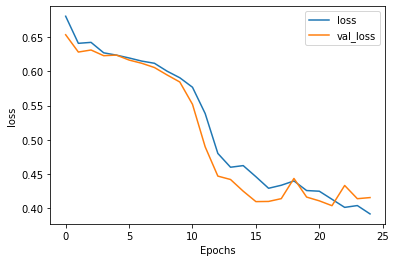

In [17]:
# Visualize the training/validation accuracy and loss
plot_graphs(model_history, "loss")

In [18]:
# Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
y_pred = np.array([1 if pred > 0.5 else 0 for pred in main_model.predict(X_val_padded)])

In [19]:
# Calculate the validation accuracy
validation_acc = sum(y_pred == y_valid)/len(y_valid)
validation_acc

0.8222222222222222

In [20]:
# Get the confusion matrix
confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_valid, y_pred=y_pred, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
confusion_matrix_df

,Pred:pos,Pred:neg
True:pos,18,11
True:neg,5,56


Taking the negative prediction from lstm for counterfactual explanantion

In [21]:
# Counts of positive and negative predictions
pd.value_counts(y_pred)

0    67
1    23
dtype: int64

In [22]:
# predict probabilities for test set
yhat_probs = main_model.predict(x_valid, verbose=0)

yhat_classes = main_model.predict(y_valid, verbose=0)

In [23]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

### ***Get the negative predictions from LSTM, for counterfactual explanations***

In [24]:
# Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
y_pred = np.array([1 if pred > 0.5 else 0 for pred in main_model.predict(x_valid)])

In [25]:
# Get these instances of negative predictions
X_pred_negative = x_valid[y_pred == 1]

print('1st negative prediction',X_pred_negative[0])
print('X_neg_predict shape', X_pred_negative.shape)

1st negative prediction [8.36363636 0.         0.71319214 0.         3.63636364 0.
 2.88832622 1.49438202 6.         0.         0.         3.23843416]
X_neg_predict shape (23, 12)


In [26]:
# Use the index of negative predictions to find the original row with the diagnosis codes
# np.where(y_pred == 1)
pred_neg_data = df.iloc[np.where(y_pred == 1)]

pred_neg_data.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
11,62.0,0,231,0,25,1,253000.0,0.9,140,1,1,10,1
13,50.0,1,168,0,38,1,276000.0,1.1,137,1,0,11,1


In [27]:
pred_pos_data = df.iloc[np.where(y_pred == 0)]

pred_pos_data.shape

(67, 13)

In [28]:
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [39]:
# Fit an unsupervised 1NN with all the positive seuquences, using 'hamming' distance
neural_model = NearestNeighbors(n_neighbors = 1, metric='hamming')
target_label = 0 
X_target_label = x_train[y_train == target_label] # training using the true labels

neural_model.fit(X_target_label)


NearestNeighbors(metric='hamming', n_neighbors=1)

In [42]:
# Get these instances of negative predictions
X_pred_negative = x_valid[y_pred == 1]

print('1st negative prediction',X_pred_negative[0])
print('X_neg_predict shape', X_pred_negative.shape)

1st negative prediction [8.36363636 0.         0.71319214 0.         3.63636364 0.
 2.88832622 1.49438202 6.         0.         0.         3.23843416]
X_neg_predict shape (23, 12)


In [41]:
# Find the closest neighbor (positive sequence) with the minimum 'hamming' distance, take it as a counterfactual
closest = neural_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_target_label[closest[:, 0]]
print(trans_results_nn.shape)
print('closest counter to the negative prediction that can change it into a positive one',trans_results_nn[0])

(23, 12)
closest counter to the negative prediction that can change it into a positive one [ 0.90909091  0.          0.71319214  0.         10.          0.
  2.88832622  0.76404494  6.85714286  0.          0.          2.09964413]


### ***Fraction of valid transformed input for 1NN baseline method***

In [44]:
x_test_counter =  trans_results_nn
# Get the total counts 
test_size = X_pred_negative.shape[0]
# For 1NN modification
fraction_success = np.sum(main_model.predict(x_test_counter) > 0.5)/test_size
print(round(fraction_success, 4))


0.1304


### **LOCAL OUTLIER FACTOR **

In [45]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
# clf.fit(X_train_padded)
clf.fit(X_target_label) # use the target class to train, instead of all

LocalOutlierFactor(contamination=0.1, novelty=True)

In [46]:
# Outlier score for 1NN baseline method
y_pred_test = clf.predict(x_test_counter)
n_error_test = y_pred_test[y_pred_test == -1].size
outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.1304


### ***EDIT DISTANCE (LEVENSHTEIN)***

In [47]:
def get_edit_distance(original, transformed):
    edit_distance_pair = [editdistance.eval(o, t) for o, t in zip(original.tolist(), transformed.tolist())]
    edit_score = np.mean(edit_distance_pair)
    
    return round(edit_score, 4)

In [48]:
##This functtion gets that how much the input sequence for negative prediction  
#is changed to its positive counter
get_edit_distance(x_test_counter, X_pred_negative)

5.8696